## Homework 7 - Jakub Kuśmierski

### Initialization of the environment

In [1]:
#Color printing
from termcolor import colored

#General data operations library
import math
import string
from datetime import datetime
import numpy as np
import skimage

#The tensorflow library
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
import tensorflow  as tf

#Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt

#Increase plots font size
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

#append path with python modules
import importlib
import sys
sys.path.append("/Users/jakubkusmierski/Desktop/Uczenie_Maszynowe_2/modules")

#Private functions
import plotting_functions as plf
importlib.reload(plf);

import emnist_functions as emnist_fcn
importlib.reload(emnist_fcn);

### Data generation 

In [2]:
##Data generation

##Function
def discGenerator(res=16):
    from skimage.draw import disk
    while True:
        center = tf.random.uniform([2], minval=0, maxval = res, dtype=tf.int32, name='center')
        radius = tf.random.uniform([1], minval=5, maxval = res//2, dtype=tf.int32, name='radius')        
        shape = (res, res)
        image = np.full(shape, 0)
        yy, xx = disk(center=center.numpy(), radius=radius.numpy()[0], shape=shape)
        image[xx,yy] = 1
        features = tf.concat(values=(center, radius), axis=0 )
        label = tf.constant(image, dtype=tf.int32, name='image')
        label = tf.reshape(label, (res, res, 1))
        yield  features, label

##Parameters
res = 256
features = []
labels = []

for index, item in enumerate(discGenerator(res)):
    if index==1024:
        break
        
    features.append(item[0])
    labels.append(item[1])

features = np.array(features).reshape(-1,3)
labels = np.array(labels).reshape(-1,res,res,1)





print(colored("Features shape:","blue"),features.shape)
print(colored("Labels shape:","blue"),labels.shape)

Features shape: (1024, 3)
Labels shape: (1024, 256, 256, 1)


### Functions to ploting results and training FC model

In [12]:
def plotDecoded(model):
    fig, axes = plt.subplots(2, 2, figsize=(5,5))
    
    data_indices = np.array([0, 1, 2, 3])
    #data_indices = np.array([6, 9, 2, 3])
    for index, axis in enumerate(axes.flat):
        data_index = data_indices[index]
        image = labels[data_index:data_index+1]

        model.evaluate(image, image)
        z = encoder.predict(image, verbose=0)
        image = decoder.predict(z, verbose=0)[0,:,:,0]
        axis.imshow(image, cmap='binary', origin='lower')
        axis.set_title(str(features[data_index])); 
        ##
        x = np.linspace(-features[data_index][2], features[data_index][2], 20)
        y = np.sqrt(features[data_index][2]**2-x**2)
        y = np.concatenate((y,-y), axis=0)
        x = np.concatenate((x,x), axis=0)
        y += features[data_index][1]
        x += features[data_index][0]
        axis.plot(x,y, "p", markersize=4, color='green') 
        axis.set_xlim([0, image.shape[0]])
        axis.set_ylim([0, image.shape[1]])
    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.4, hspace=0.4)
    

def plotGenerated(model, params):
   
    fig, axes = plt.subplots(2, 2, figsize=(5,5))
    
    for index, axis in enumerate(axes.flat):
        features = tf.Variable([params[index]], dtype=tf.int16)
        image = model(features)[0]
        axis.imshow(image, cmap='binary', origin='lower')
        axis.set_title(str(params[index])); 
        ##
        x = np.linspace(-params[index][2], params[index][2], 10)
        y = np.sqrt(params[index][2]**2-x**2)
        y = np.concatenate((y,-y), axis=0)
        x = np.concatenate((x,x), axis=0)
        x += params[index][0]
        y += params[index][1]
        axis.plot(x,y, "p", markersize=4, color='green')
        axis.set_xlim(0,image.shape[0])
        axis.set_ylim(0,image.shape[1])
    plt.subplots_adjust(bottom=0.02, left=0.02, right=0.98, wspace=0.4, hspace=0.4)
    
    
def trainModel(model, nEpochs):
   
    initial_learning_rate = 1E-3
    batchSize = 32
      
    nStepsPerEpoch = int(len(labels)/batchSize)
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                    decay_steps=nStepsPerEpoch*10,
                    decay_rate=0.95,
                    staircase=False)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
                loss='binary_crossentropy', metrics=[])
    
    #run training
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                                           patience=15, verbose=1)
    callbacks = [early_stop_callback]
    #callbacks = []
    
    history = model.fit(x=features, y=labels,
                        epochs=nEpochs, 
                        callbacks=callbacks,
                        validation_split = 0.1,
                        verbose=1)
    
    plf.plotTrainHistory(history)
    print(colored("Evaluation on training dataset:","blue"))
    model.evaluate(features, labels)

### Autoencoder model

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 4, 4, 1)        │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,105 (74.63 KB)

 Trainable params: 19,105 (74.63 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_36             │ (None, 8, 8, 32)       │           320 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_37             │ (None, 16, 16, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_38             │ (None, 32, 32, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_39             │ (None, 64, 64, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_40             │ (None, 128, 128, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_41             │ (None, 256, 256, 32)   │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_42             │ (None, 256, 256, 1)    │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autodecoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Sequential)            │ (None, 4, 4, 1)        │        19,105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Sequential)            │ (None, 256, 256, 1)    │        46,849 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,954 (257.63 KB)

 Trainable params: 65,954 (257.63 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


2025-05-07 17:50:40.612602: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


Epoch 1/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 5s 110ms/step - loss: 0.6719 - val_loss: 0.4677
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.4724 - val_loss: 0.2462
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.2581 - val_loss: 0.2021
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.2162 - val_loss: 0.1814
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.2069 - val_loss: 0.1653
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.1779 - val_loss: 0.1380
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.1579 - val_loss: 0.1190
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.1350 - val_loss: 0.1029
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.1155 - val_loss: 0.0916
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - loss: 0.0989 - val_loss: 0.0816
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: 0.0912 - val_loss: 0.0715
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/ste

2025-05-07 17:59:57.431415: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0439
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0129
CPU times: user 5min, sys: 1min 42s, total: 6min 42s
Wall time: 9min 17s


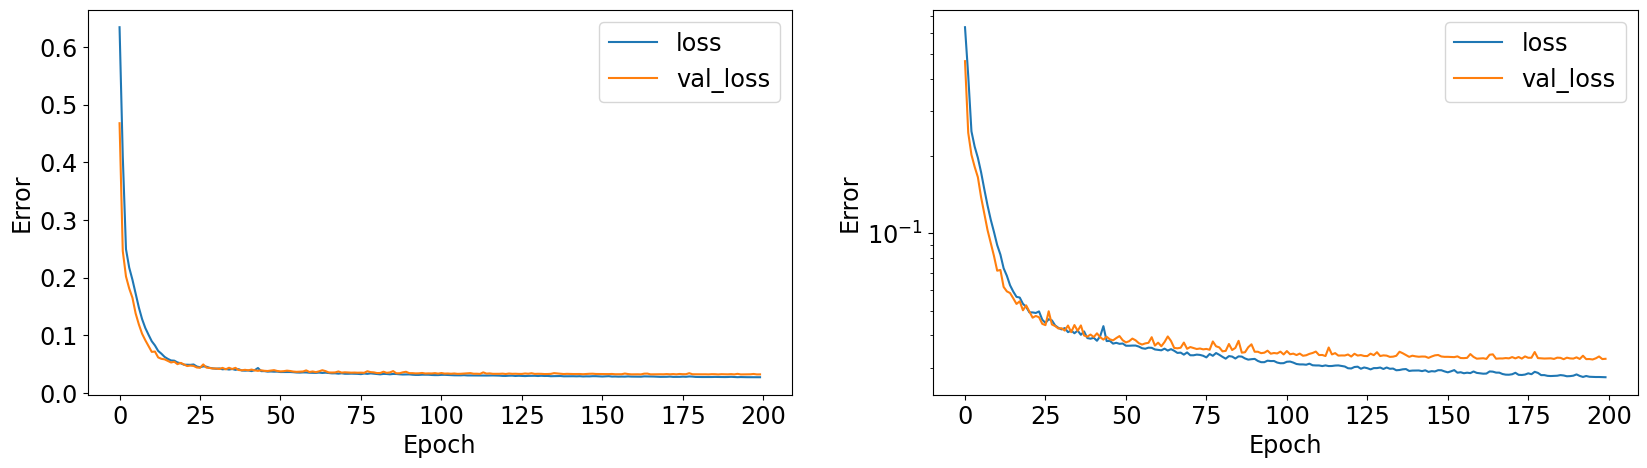

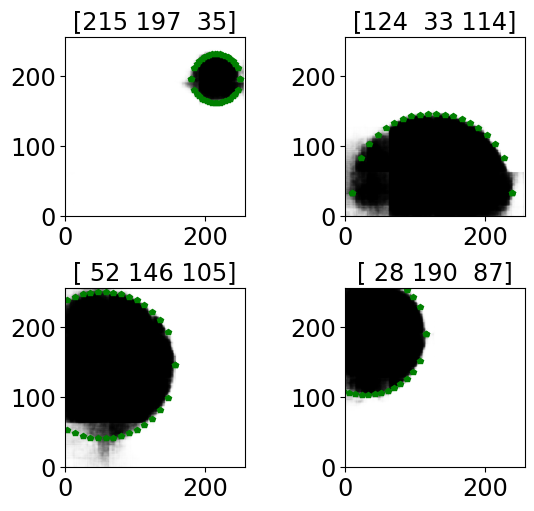

In [11]:
%%time
## autoencoder model

encoder = tf.keras.Sequential(layers = [tf.keras.Input(shape=(256,256,1)),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2,2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2,2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.MaxPooling2D((2,2), padding='same'),
                                        tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', activation='relu')],
                              name = 'encoder')

encoder.summary()

decoder = tf.keras.Sequential(layers = [tf.keras.Input(shape=(4,4,1)),
                                        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
                                        tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding='same', activation='sigmoid')],
                              name = 'decoder')

decoder.summary()

model_cnn_ae = tf.keras.Sequential(layers = [encoder,decoder], name = 'autodecoder')
model_cnn_ae.summary()
model_cnn_ae.predict(labels[:1])


initial_learning_rate = 1E-3
batchSize = 64
nEpochs = 200
    
nStepsPerEpoch = int(len(labels)/batchSize)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                decay_steps=nStepsPerEpoch*10,
                decay_rate=0.95,
                staircase=False)

model = model_cnn_ae
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss='binary_crossentropy')

history = model.fit(x=labels, y=labels,
                        epochs=nEpochs, 
                        validation_split = 0.1,
                        verbose=1)

model.evaluate(labels, labels)    
plf.plotTrainHistory(history)


#Evaluation
plotDecoded(model_cnn_ae)

### Fuly conected model

Model: "FC_disc_generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 65536)          │     8,454,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 256, 256, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,456,384 (32.26 MB)

 Trainable params: 8,456,384 (32.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


2025-05-07 18:11:38.666678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 6.7839 - val_loss: 4.9782
Epoch 2/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 5.0098 - val_loss: 4.1903
Epoch 3/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 4.3737 - val_loss: 3.8003
Epoch 4/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.9180 - val_loss: 3.6324
Epoch 5/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.8194 - val_loss: 3.4711
Epoch 6/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.6341 - val_loss: 3.3602
Epoch 7/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.5866 - val_loss: 3.2591
Epoch 8/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.5115 - val_loss: 3.1848
Epoch 9/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.4111 - val_loss: 3.1064
Epoch 10/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 3.3458 - val_loss: 3.0581
Epoch 11/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.2794 - val_loss: 2.9951
Epoch 12/200
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 3.2

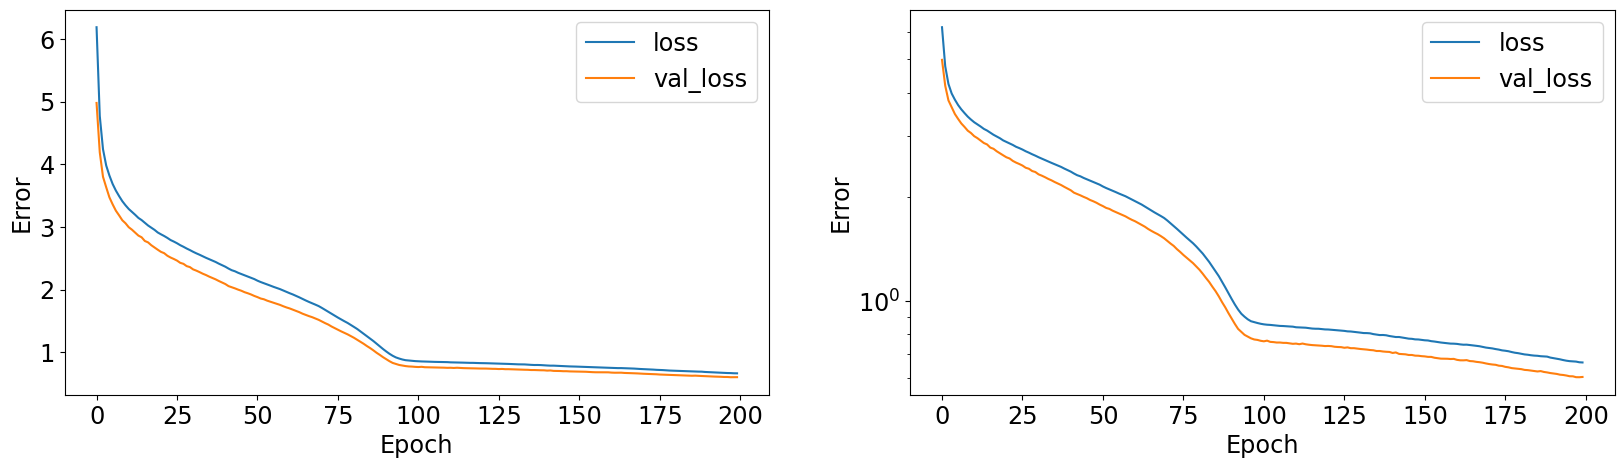

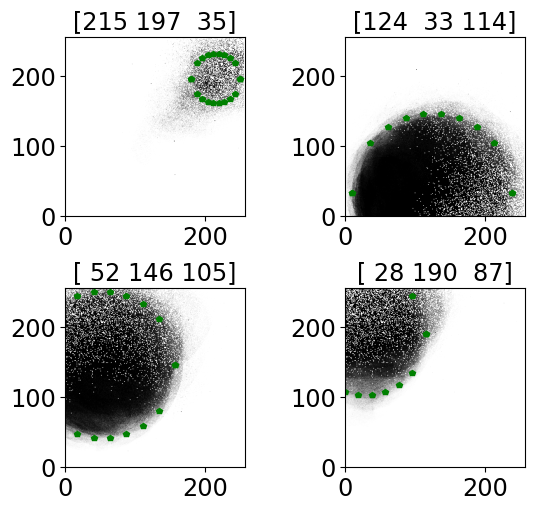

In [14]:
%%time
##fully connected model

model_fc = tf.keras.Sequential(layers = [tf.keras.Input(shape=(3,)),
                                      ##
                                       tf.keras.layers.Dense(16, activation='relu', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                       tf.keras.layers.Dense(128, activation='relu', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                       tf.keras.layers.Dense(256*256, activation='sigmoid', 
                                          bias_initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
                                          kernel_initializer="HeNormal"),
                                      tf.keras.layers.Reshape((256,256,1)),                                                                
                                      ##
                                     ],
                                     name="FC_disc_generator")
model_fc.summary()

trainModel(model_fc, nEpochs=200)



#model evaluation
params = features[0:4]
plotGenerated(model_fc, params)